based on: [0.483662871, 1.0, 26.2359775, 0.00111820675, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]

returned NPV for the number of reactors [10584234, 10619217, 10654200]
returned NPV for temperature [10591841.798075095, 10590804.39098942, 10589358.933562998, 10587778.514076617, 10586512.797784012, 10585495.881161923, 10584486.935808586, 10583354.552073402, 10582012.507853094, 33737122890.439342]
returned NPV for debt [10585674.555232147, 10587298.947765334, 10588926.408308163, 10590556.944393268, 10592190.563575603, 10593827.273432517, 10595467.081563842, 10597109.995591957, 10598756.02316187, 10600405.171941303, 10602057.44962076, 10603712.863913612, 10605371.422556177, 10607033.133307796, 10608698.003950909, 10610366.042291142, 10612037.256157387, 10613711.653401876, 10615389.241900267, 10617070.029551724, 10618754.024278998, 10620441.23402851, 10622131.666770432, 10623825.330498768, 10625522.233231438, 10627222.383010367, 10628925.787901554, 10630632.455995174, 10632342.395405645, 10634055

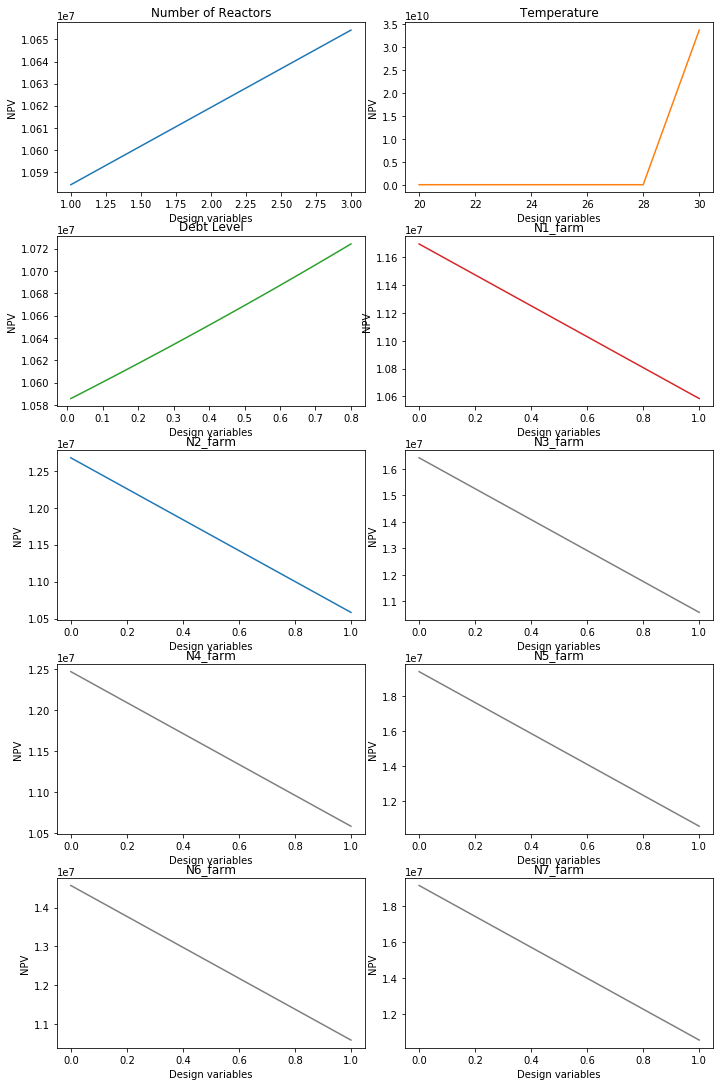

In [149]:
import pandas as pd
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from sko.GA import GA

from constants import *
from sensitivity_cost_module import do_all_list_cp,system_npv,JtokWh ,farmer_npv
from digesterModule import digester
import sensitivity_cost_module as C2
import Transport as T
import biogas as B
import pickle
from math import inf

# Variables we want to keep track in DOE
farm=[]
system=[]
# with open('data_transport.p', 'rb') as fp:
#     dict_T = pickle.load(fp)
with open('full_transp.p', 'rb') as fp:
    dict_T = pickle.load(fp)

import matplotlib.pyplot as plt
import autograd.numpy as np

vector = [4.83662871e-01, 1.00000000e+00, 2.62359775e+01, 
        1.11820675e-03, 1.00000000e+00, 0.00000000e+00,0.00000000e+00, 
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00,0.00000000e+00]


def biodigestor(dv_n,dv_in,printt=False,pen=True):
    
    global vector
    
    ##DESIGN VARIABLES##
    n_g = 1 #number of reactor
    Tdig = vector[2] #operating temperature
    debt_level = vector[3] #Portion of total capex required funded with debt
    active_farms = np.ones(7)
    
    #print('dv_in:',dv_in)
    if dv_n==1: #Vgburn
        temp = 1
    elif dv_n==2: #generator
        n_g = dv_in
    elif dv_n==3: #temperature
        Tdig = dv_in
    elif dv_n==4: #debt
        debt_level = dv_in
    elif dv_n==5: #farm1
        active_farms[0] = dv_in
        print('farm1',dv_in)
        print(active_farms)
    elif dv_n==6: #farm2
        active_farms[1] = dv_in
        print('farm2',dv_in)
        print(active_farms)
    elif dv_n==7: #farm3
        active_farms[2] = dv_in
        print('farm3',dv_in)
        print(active_farms)
    elif dv_n==8: #farm4
        active_farms[3] = dv_in
        print('farm4',dv_in)
        print(active_farms)
    elif dv_n==9: #farm5
        active_farms[4] = dv_in
        print('farm5',dv_in)
        print(active_farms)
    elif dv_n==10: #farm6
        active_farms[5] = dv_in
        print('farm6',dv_in)
        print(active_farms)
    elif dv_n==11: #farm7
        active_farms[6] = dv_in
        print('farm7',dv_in)
        print(active_farms)
        
    

#     active_farms= vector[4:11] 
#     active_farms = [0 if num<1 else 1 for num in active_farms ]

    if printt:
        [distance, wIn, total_solids_perc, wComp] = T.load_data(*active_farms,printt)
    else:
        [distance, wIn, total_solids_perc, wComp] = dict_T[tuple(active_farms)]
    
    [W_a, typ, V_d, G_in, G_comp, digOut, digOut_comp] = digester(wIn,wComp,Tdig)
    # H_needed = JtokWh(H_needed*1000)
    # print('----')
    
    #biogas module
    V_g = B.biomethane(G_in, G_comp) #biomethane
    f_p = B.biofertilizer(digOut) 
    ghg_r, ghg_c = B.ghg(W_a, wComp, G_in, G_comp) #ghg_r: released gas, ghg_c: captured gas
    bgm_total = B.bgm_cost(G_comp, G_in, digOut)
    
    #COST Module

    V_g =V_g*working_days
    ghg = pd.DataFrame()
    ghg['ghg_lf']=ghg_r
    ghg['ghg_tech']=ghg_c
    ghg['gas']= ['CH4','CO2','NOX','SOX']
    list_ghg = []
    for gas in ['CH4','CO2','NOX','SOX']:
        list_ghg.append(ghg[ghg['gas']==gas].values.flatten().tolist())
    list_ghg = do_all_list_cp(W_a,distance,list_ghg)
    
    #print("n_g",n_g)
    V_gburn = vector[0]*V_g

    return -farmer_npv(n_g,V_gburn,V_d,typ,distance,f_p,V_g,debt_level,e_c,e_priceB,f_used,p_bf,printt,pen)



import numpy as np

print('based on:',vector)
print()

#number of reactor
ngs = np.linspace(1, 3,3)
returned_dv1 = []
for ng in ngs:
    returned_dv1.append(biodigestor(2,ng))
print('returned NPV for the number of reactors',returned_dv1)

#temperature
Tdigs = np.linspace(20, 30,10,dtype=int)
returned_dv2 = []
for dig in Tdigs:
    returned_dv2.append(biodigestor(3,dig))
print('returned NPV for temperature',returned_dv2)

#debt
debts = np.linspace(1,80,80,dtype=int)/100
returned_dv3 = []
for debt in debts:
    returned_dv3.append(biodigestor(4,debt))
print('returned NPV for debt',returned_dv3)

#farm1
farm1 = np.linspace(0,1,2,dtype=int)
returned_dv4 = []
for farm in farm1:
    returned_dv4.append(biodigestor(5,farm))
print('returned NPV for Farm1',returned_dv4)

#farm2
farm2 = np.linspace(0,1,2,dtype=int)
returned_dv5 = []
for farm in farm2:
    returned_dv5.append(biodigestor(6,farm))
print('returned NPV for Farm2',returned_dv5)

#farm3
farm3 = np.linspace(0,1,2,dtype=int)
returned_dv6 = []
for farm in farm1:
    returned_dv6.append(biodigestor(7,farm))
print('returned NPV for Farm3',returned_dv6)

#farm4
farm4 = np.linspace(0,1,2,dtype=int)
returned_dv7 = []
for farm in farm4:
    returned_dv7.append(biodigestor(8,farm))
print('returned NPV for Farm4',returned_dv6)

#farm5
farm5 = np.linspace(0,1,2,dtype=int)
returned_dv8 = []
for farm in farm5:
    returned_dv8.append(biodigestor(9,farm))
print('returned NPV for Farm5',returned_dv8)

#farm6
farm6 = np.linspace(0,1,2,dtype=int)
returned_dv9 = []
for farm in farm6:
    returned_dv9.append(biodigestor(10,farm))
print('returned NPV for Farm6',returned_dv9)

#farm7
farm7 = np.linspace(0,1,2,dtype=int)
returned_dv10 = []
for farm in farm7:
    returned_dv10.append(biodigestor(11,farm))
print('returned NPV for Farm7',returned_dv10)


fig, axs = plt.subplots(5, 2,figsize=(10,15))
axs[0, 0].plot(ngs, returned_dv1)
axs[0, 0].set_title('Number of Reactors')
axs[0, 1].plot(Tdigs, returned_dv2, 'tab:orange')
axs[0, 1].set_title('Temperature')
axs[1, 0].plot(debts, returned_dv3, 'tab:green')
axs[1, 0].set_title('Debt Level')
axs[1, 1].plot(farm1, returned_dv4, 'tab:red')
axs[1, 1].set_title('N1_farm')
axs[2, 0].plot(farm2, returned_dv5, 'tab:blue')
axs[2, 0].set_title('N2_farm')
axs[2, 1].plot(farm3, returned_dv6, 'tab:grey')
axs[2, 1].set_title('N3_farm')
axs[3, 0].plot(farm4, returned_dv7, 'tab:grey')
axs[3, 0].set_title('N4_farm')
axs[3, 1].plot(farm5, returned_dv8, 'tab:grey')
axs[3, 1].set_title('N5_farm')
axs[4, 0].plot(farm6, returned_dv9, 'tab:grey')
axs[4, 0].set_title('N6_farm')
axs[4, 1].plot(farm7, returned_dv10, 'tab:grey')
axs[4, 1].set_title('N7_farm')
fig.tight_layout()

for ax in axs.flat:
    ax.set(xlabel='Design variables', ylabel='NPV')


NameError: name 'x' is not defined

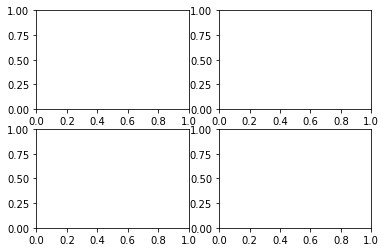

In [132]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x, y)
axs[0, 0].set_title("main")
axs[1, 0].plot(x, y**2)
axs[1, 0].set_title("shares x with main")
axs[1, 0].sharex(axs[0, 0])
axs[0, 1].plot(x + 1, y + 1)
axs[0, 1].set_title("unrelated")
axs[1, 1].plot(x + 2, y + 2)
axs[1, 1].set_title("also unrelated")
fig.tight_layout()

In [ ]:
## GRADIENT
from autograd import grad  
grad_bio = grad(biodigestor)



print('gradient',np.gradient(np.array( returned_v, dtype=float), axis=0))


from autograd import jacobian
dAdk1 = jacobian(biodigestor)
#dAdk_1 = jacobian(biodigestor, 2)

plt.plot(ngs, np.abs(dAdk1(returned_v)))
#plt.plot(ngs, np.abs(dAdk_1(returned_v)))
plt.xlim([0, 0.5])
plt.ylim([0, 0.1])
plt.xlabel('t')
plt.legend(['$S_{k1}$', '$S_{k\_1}$'])


# plt.plot(ngs, grad(ngs))
# plt.xlim([1, 10])
# plt.ylim([46751289, 47751289])
# plt.xlabel('Number of Reactor')
# plt.ylabel('NPV')


# import autograd.numpy as np
# A0 = 1.0
# def A(t, k1, k_1):
#     return A0 / (k1 + k_1) * (k1 * np.exp(-(k1 + k_1) * t) + k_1)
# %matplotlib inline
# import matplotlib.pyplot as plt
# t = np.linspace(0, 0.5)
# k1 = 3.0
# k_1 = 3.0
# plt.plot(t, A(t, k1, k_1))
# plt.xlim([0, 0.5])
# plt.ylim([0, 1])
# plt.xlabel('t')
# plt.ylabel('A')

* Point out the design variables in the code
* confirm x* and function output
* which parameters to test with?
* All the codes are finalized? Which one I can use?
* If grad is not working, any possible workaround? e.g. gradienting the results?